In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import math
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats
import imodelsx.viz
import json
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import data
import joblib
from matplotlib.gridspec import GridSpec
from scipy.stats import spearmanr
LEVELS = ['Very Negative', 'Negative', 'Neutral',
          'No response', 'Positive', 'Very Positive']

# get data for example site
files_dict = data.load_files_dict_single_site()
site = 'Charlotte'
df = files_dict[site]
qs, responses_df, themes_df = data.split_single_site_df(df)

/home/chansingh/.env/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/.env/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/chansingh/.env/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


success: 18
fail: ['Cincinnati', 'Columbus']


### Aggregate sentiment plots

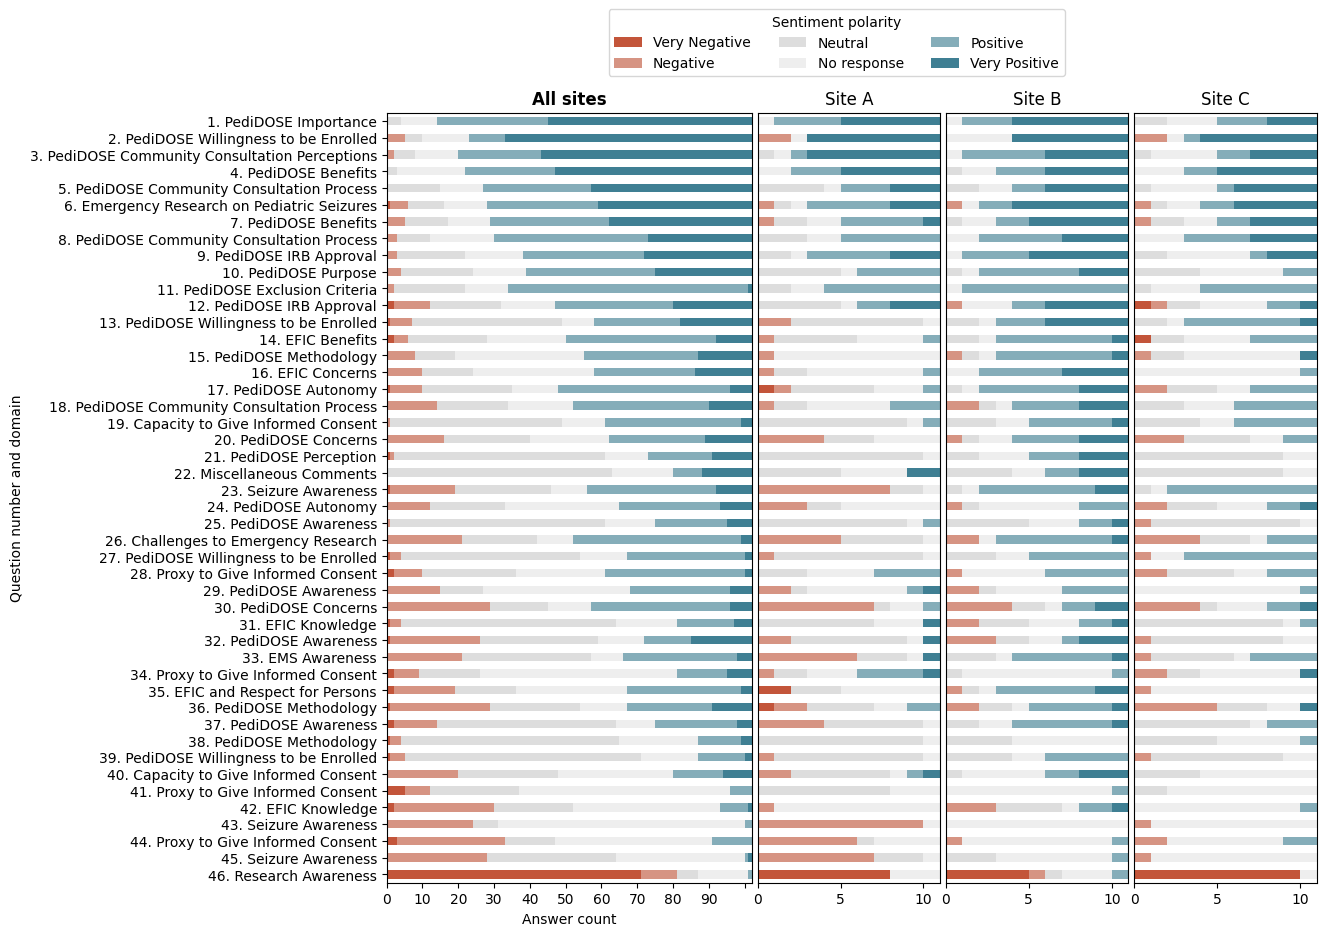

In [2]:
sent_dfs = []
#
sites = ['Atlanta', 'Columbus', 'WashingtonDC'] + \
    ['Charlotte', 'Houston', 'Portland'] + \
    ['Dallas', 'Seattle', 'Tucson']
for site in sites:
    sent_df = joblib.load(
        join(data.PROCESSED_DIR, f'sent_df_{site}_gpt-4.pkl'))
    # sent_df = sent_df.sort_values(by=levels, ascending=False)
    sent_dfs.append(sent_df)

sum_df = pd.concat(sent_dfs).groupby(level=0).sum()

# make plot
# sum_df = sum_df.sort_values(by=LEVELS, ascending=False)
# sum_index_sorted = sum_df.index
mean = -2 * sum_df['Very Negative'] + -1 * sum_df['Negative'] + \
    1 * sum_df['Positive'] + 2 * sum_df['Very Positive']
sum_index_sorted = mean.sort_values().index
sum_df = sum_df.reindex(sum_index_sorted)

colors = sns.diverging_palette(20, 220, n=6).as_hex()
colors = colors[:2] + ['#ddd', '#eee'] + colors[-2:]

fig = plt.figure(figsize=(12, 10))
gs = GridSpec(1, 4, width_ratios=[2, 1, 1, 1], wspace=0.025)


# first plot
ax1 = fig.add_subplot(gs[0])
sum_df.plot(kind='barh', stacked=True, color=colors, ax=ax1, legend=False)
plt.xlim(0, sum_df.sum(axis=1).max())
# remove label for final xtick
labels = [str(i) if i % 10 == 0 else '' for i in range(
    0, int(sum_df.sum(axis=1).max()) + 1, 10)]
labels[-1] = ''
plt.xticks(range(0, int(sum_df.sum(axis=1).max()) + 1, 10),
           labels=labels)
plt.yticks(range(46),
           labels=[f'{len(sent_df) - i}. {v}' for i, v in enumerate(
               df['Domain'].values[sum_df.index.values])])
fig.legend(bbox_to_anchor=(0.5, 0.95), loc='center',
           ncol=3, title='Sentiment polarity')
plt.xlabel('Answer count')
plt.title('All sites', fontweight='bold')
plt.ylabel('Question number and domain')

sites_examples = ['Atlanta', 'Columbus', 'WashingtonDC']
for i, site in enumerate(sites_examples):
    ax = fig.add_subplot(gs[i+1])
    sent_df = sent_dfs[i]
    sent_df = sent_df.reindex(sum_index_sorted)
    sent_df.plot(kind='barh', stacked=True, color=colors, ax=ax, legend=False)
    plt.xlim(0, sent_df.sum(axis=1).max())
    plt.yticks([])
    plt.ylabel('')
    # plt.title(data.RENAME_SITE_DICT.get(site, site))
    plt.title(f'Site {"ABC"[i]}')
plt.savefig(f'../figs/sentiment_agg.pdf', bbox_inches='tight')
plt.savefig(f'../figs/sentiment_agg.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
total_responded = sum_df.sum().sum() - sum_df['No response'].sum().sum()
print(total_responded, 'responses', sum_df['No response'].sum(), 'no response')
print('breakdown', sum_df.sum(), round((100 * sum_df.sum() / total_responded)))

In [ ]:
# no limit display
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    d = df.iloc[sum_index_sorted][::-1][['Domain', 'Subcategory']]
    d['Question order'] = d.index
    d.insert(loc=0, column='Question number', value=np.arange(1, len(d) + 1))
    # display(d)
    d.to_csv('../figs/question_list.csv', index=False)

# Human annotation

**Select questions**

In [ ]:
# # original function filter 10 questions that have many themes (these tend to be more interesting)
# # select questions
# def get_num_themes(df):
#     num_themes_list = []
#     for question_num in range(len(df)):
#         question, responses, theme_dict = data.get_data_for_question_single_site(
#             question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
#         num_themes_list.append(len(theme_dict))
#     return np.array(num_themes_list)
#     # df['num_themes'] = num_themes_list
#     # return df


# num_themes = np.zeros(46)
# SITES = ['Atlanta', 'Columbus', 'WashingtonDC']
# for site in sites:
#     df = files_dict[site]
#     num_themes += get_num_themes(df)
# idx = pd.Series(num_themes).sort_values(ascending=False)
# questions_selected = idx.index[:10]

# instead pick 3 most positive, 3 middle, and 3 most negative
mid = 46 // 2
sorted_qs = list(sum_index_sorted)
questions_selected = sorted_qs[:3] + sorted_qs[mid-1:mid+2] + sorted_qs[-3:]

# save these questions
pd.Series(questions_selected).to_csv(
    '../figs/human/sentiment_questions_selected.csv', index=False, header=False)

**Select random answers to questions (up to 15 per question)**

In [ ]:
# # read in responses from all sites
# resps_dict = defaultdict(list)
# for question_num in questions_selected:
#     for site in ['Atlanta', 'Columbus', 'WashingtonDC']:
#         df = files_dict[site]
#         question, responses, theme_dict = data.get_data_for_question_single_site(
#             question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)
#         resps_dict[question_num] += list(responses)
# assert np.all(np.array(list(len(v) for v in resps_dict.values())) == 33)


# # randomly select up to 15 non-nan responses for each question and record their indices (less if there are fewer than 15)
# rng = np.random.default_rng(13)
# resps_idx_selected = defaultdict(list)
# resps_selected = {}
# for question_num in questions_selected:
#     resps = resps_dict[question_num]
#     indices = np.arange(33)[~pd.isna(resps)]
#     indices_selected = rng.choice(
#         indices, size=min(len(indices), 15), replace=False).tolist()
#     resps_idx_selected[question_num] = indices_selected
#     resps_selected[question_num] = [resps[i] for i in indices_selected]

# # put into a big defaultdict
# dd = defaultdict(list)
# for question_num in questions_selected:
#     for i, resp in enumerate(resps_selected[question_num]):
#         dd['Question number'].append(question_num)
#         dd['Response number'].append(resps_idx_selected[question_num][i])

#         dd['Question'].append(qs[question_num])
#         dd['Response'].append(resp)

# # dump
# with open('../figs/human/sentiment_idx_selected.json', 'w') as f:
#     json.dump(resps_idx_selected, f, indent=4)
# ddf = pd.DataFrame.from_dict(dd)
# ddf.to_csv('../figs/human/sentiment_template.csv', index=False)
# ddf.to_pickle('../figs/human/sentiment_template.pkl')

### Analyze human results

Load human annotations into a df called `annotations_df`

In [2]:
annots = {
    'hum1': 'human1',
    'hum2': 'human2',
    'hum3': 'human3',
}

# template = pd.read_pickle('../figs/human/sentiment_template.pkl')
annotations_df = pd.read_csv('../figs/human/sentiment_template.csv')
for k, v in annots.items():
    hum = pd.read_csv(f'../figs/human/collected/sentiment_{v}.csv', skiprows=1)

    def remove_all_whitespace(s):
        return ''.join(s.split())

    # check for matching index, value range
    assert hum.shape[0] == annotations_df.shape[
        0], f'Shape mismatch for {k}: {hum.shape[0]} vs {annotations_df.shape[0]}'
    assert np.all(hum['Response number'].astype(str).apply(remove_all_whitespace).values ==
                  annotations_df['Response number'].astype(str).apply(remove_all_whitespace).values), f'Error for hum {k}'

    # add col
    annotations_df[k] = hum['Rating'].values.astype(int)
    assert np.all(annotations_df[k].values >= 1)
    assert np.all(annotations_df[k].values <= 5)

checkpoints_all = [
    'gpt-4',
    'gpt-35-turbo',
    'meta-llama/Llama-2-70b-hf',
    'meta-llama/Llama-2-7b-hf',
    'mistralai/Mistral-7B-v0.1',  # 'mistralai/Mixtral-8x7B-v0.1'
]


def find_starting_number(s):
    # if s starts with a number or a number with decimal places, return that number
    # otherwise return nan
    s = str(s).strip()
    if s == 'nan':
        return np.nan
    ans = ''
    while len(s) > 0 and (s[0].isdigit() or s[0] == '.'):
        ans += s[0]
        s = s[1:]
    return float(ans) if len(ans) > 0 else np.nan


for checkpoint in checkpoints_all:
    sites = ['Atlanta', 'Columbus', 'WashingtonDC']
    sent_dfs = []
    for site in sites:
        sent_df = joblib.load(join(
            data.PROCESSED_DIR, f'sentiments_df_{site}_{checkpoint.split("/")[-1]}.pkl'))
        sent_dfs.append(sent_df)

    sent_dfs[0].columns = np.arange(0, 11)
    sent_dfs[1].columns = np.arange(11, 22)
    sent_dfs[2].columns = np.arange(22, 33)
    sent_llm_full = pd.concat(sent_dfs, axis=1).values
    annotations_df[checkpoint] = annotations_df.apply(
        lambda row: sent_llm_full[row['Question number'], row['Response number']], axis=1)
    annotations_df[checkpoint] = annotations_df[checkpoint].apply(
        find_starting_number)
llms_to_ensemble = ['gpt-4', 'gpt-35-turbo',
                    'mistralai/Mistral-7B-v0.1',  # 'meta-llama/Llama-2-70b-hf',
                    # 'mistralai/Mixtral-8x7B-v0.1',
                    ]

annotations_df['Human ensemble'] = annotations_df[[
    'hum1', 'hum2', 'hum3']].mean(axis=1)
annotations_df = annotations_df.rename(columns={
    'hum1': 'Human 1',
    'hum2': 'Human 2',
    'hum3': 'Human 3',
})


annotations_df.columns = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), annotations_df.columns))
checkpoints_all = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), checkpoints_all))
llms_to_ensemble = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), llms_to_ensemble))
annotations_df['LLM ensemble'] = annotations_df[llms_to_ensemble].mean(axis=1)


# note: GPT-4 and GPT-3.5 Turbo got swapped while running, need to swap their column vals back
col_gpt4 = annotations_df['GPT-4'].copy()
col_gpt35 = annotations_df['GPT-3.5 Turbo'].copy()
annotations_df['GPT-4'] = col_gpt35
annotations_df['GPT-3.5 Turbo'] = col_gpt4

Compute correlations between the columns of `annotations_df` and storr in `corr_df`

In [3]:
# make sure to apply this across all llms
notna = np.ones(len(annotations_df), dtype=bool)
for ckpt in checkpoints_all:
    notna &= annotations_df[ckpt].apply(find_starting_number).notna()
print('num annots', notna.sum())

checkpoints_all_hum = ['Human 1', 'Human 2', 'Human 3', 'Human ensemble'] + \
    ['LLM ensemble'] + checkpoints_all
corr = np.zeros((len(checkpoints_all_hum), len(checkpoints_all_hum)))
for r, cr in enumerate(checkpoints_all_hum):
    for c, cc in enumerate(checkpoints_all_hum):
        x = annotations_df[cr][notna]
        y = annotations_df[cc][notna]
        corr[r, c] = np.corrcoef(x, y)[0, 1]  # spearmanr(x, y)
        # corr[r, c] = cohen_kappa_score(x, y)

# convert to df

# labels[0] = 'Human 1'
# labels[1] = 'Human 2'
# labels[2] = 'Human 3'
labels = checkpoints_all_hum
print(labels, corr.shape)
corr_df = pd.DataFrame(corr,
                       index=labels,
                       columns=labels)

# sort by corr with human
ind = corr_df.sort_values(by='Human ensemble', ascending=False).index
ind.values[:4] = ['Human 1', 'Human 2', 'Human 3', 'Human ensemble']
corr_df = corr_df.reindex(ind)[ind]

# Replace correlations with Human ensemble by excluding the human
cols = ['Human 1', 'Human 2', 'Human 3']
hum_corrs = []
for i, c in enumerate(cols):
    avg_excluding_c = annotations_df[[
        col for col in cols if col != c]].mean(axis=1)
    hum_corrs.append(np.corrcoef(
        annotations_df[c][notna], avg_excluding_c[notna])[0, 1])
# print(hum_corrs)
corr_df.loc[cols, 'Human ensemble'] = hum_corrs
corr_df.loc['Human ensemble', cols] = hum_corrs

# Replace correlations with LLM ensemble by excluding the LLM
cols = list(map(lambda x: imodelsx.viz.CHECKPOINTS_RENAME_DICT.get(
    x, x), llms_to_ensemble))
llm_corrs = []
for i, c in enumerate(cols):
    avg_excluding_c = annotations_df[[
        col for col in cols if col != c]].mean(axis=1)
    llm_corrs.append(np.corrcoef(
        annotations_df[c][notna], avg_excluding_c[notna])[0, 1])
# print(llm_corrs)
corr_df.loc[cols, 'LLM ensemble'] = llm_corrs
corr_df.loc['LLM ensemble', cols] = llm_corrs

num annots 105
['Human 1', 'Human 2', 'Human 3', 'Human ensemble', 'LLM ensemble', 'GPT-4', 'GPT-3.5 Turbo', 'LLAMA-2 (70B)', 'LLAMA-2 (7B)', 'Mistral (7B)'] (10, 10)


Make main plot

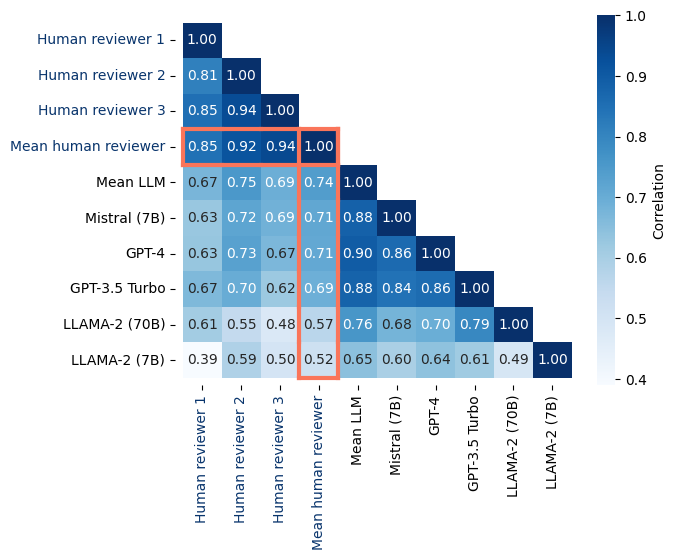

In [4]:
# corr_df = corr_df.iloc[1:, 1:]
mask = np.triu(np.ones_like(corr_df, dtype=bool))
mask[np.diag_indices_from(mask)] = False

rename = {
    'Human 1': 'Human reviewer 1',
    'Human 2': 'Human reviewer 2',
    'Human 3': 'Human reviewer 3',
    'Human ensemble': 'Mean human reviewer',
    'LLM ensemble': 'Mean LLM',
}
corr_df = corr_df.rename(columns=rename, index=rename)
ax = sns.heatmap(
    corr_df,
    annot=True, fmt='.2f',
    cmap=sns.color_palette("Blues", as_cmap=True), cbar_kws={'label': 'Correlation'},
    mask=mask,
)

# outline the first row of the elements in the heatmap
color = '#fa755a'
lw = 3
roffset = 3.5
coffset = 0.5
shape = corr_df.shape
r = 0
# color = 'gray'
alpha = 1
for c in range(3, shape[1]):
    rx = r + roffset
    cx = c + coffset
    if c == 2:
        plt.plot([rx - 0.5, rx + 0.5],
                 [cx - 0.5, cx - 0.5], color=color, lw=lw, alpha=alpha)
    if c == shape[1] - 1:
        plt.plot([rx - 0.5, rx + 0.5],
                 [cx + 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)
    plt.plot([rx - 0.5, rx - 0.5],
             [cx - 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)
    plt.plot([rx + 0.5, rx + 0.5],
             [cx - 0.5, cx + 0.5], color=color, lw=lw, alpha=alpha)

roffset = 0.5
coffset = 0.5
c = 3
for r in range(0, 4):
    kwargs = {
        'color': color,
        'lw': lw,
        # 'linestyle': '-',
        # 'marker': 'None',
        # 'alpha': 0.5,
    }
    rx = r + roffset
    cx = c + coffset
    # if c == 2:
    plt.plot([rx - 0.5, rx + 0.5],
             [cx - 0.5, cx - 0.5], **kwargs)
    # if c == shape[1] - 1:
    plt.plot([rx - 0.5, rx + 0.5],
             [cx + 0.5, cx + 0.5], **kwargs)
    if r == 0:
        plt.plot([rx - 0.5, rx - 0.5],
                 [cx - 0.5, cx + 0.5], **kwargs)
    if r == 3:
        plt.plot([rx + 0.5, rx + 0.5],
                 [cx - 0.5, cx + 0.5], **kwargs)

# set the color of first three xticklabels and yticklabels to blue
for i, t in enumerate(ax.get_xticklabels()):
    if i < 4:
        t.set_color('#08346c')
for i, t in enumerate(ax.get_yticklabels()):
    if i < 4:
        t.set_color('#08346c')


plt.xlim(-.2, shape[0])
plt.ylim(shape[1] + 0.2, -.2)
# plt.ylabel('Annotator')
# plt.xlabel('Annotator')
plt.savefig('../figs/sentiment_correlation.pdf', bbox_inches='tight')
plt.savefig('../figs/sentiment_correlation.png', bbox_inches='tight', dpi=300)
plt.show()

In [5]:
def r_confidence_interval(r, alpha, n):
    def _r_to_z(r):
        return math.log((1 + r) / (1 - r)) / 2.0

    def _z_to_r(z):
        e = math.exp(2 * z)
        return ((e - 1) / (e + 1))

    z = _r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (round(_z_to_r(lo), 2), round(_z_to_r(hi), 2))


print('interval human-LLM', r_confidence_interval(0.741484, 0.05, 123))
print('interval annotators', np.mean([0.813302, 0.850014, 0.935228]), r_confidence_interval(
    np.mean([0.813302, 0.850014, 0.935228]), 0.05, 123))
print('interval each human-LLM',
      [r_confidence_interval(x, 0.05, 123) for x in [0.845929, 0.915878, 0.941113]])
print('interval human1-human2',
      [r_confidence_interval(0.813302, 0.05, 123)])

interval human-LLM (0.65, 0.81)
interval annotators 0.8661813333333334 (0.81, 0.9)
interval each human-LLM [(0.79, 0.89), (0.88, 0.94), (0.92, 0.96)]
interval human1-human2 [(0.74, 0.87)]


In [6]:
vals = corr_df.loc['Mean human reviewer', [
    'Human reviewer 1', 'Human reviewer 2', 'Human reviewer 3']]
print('Human ensemble vs human', vals.mean(), vals.sem(ddof=0))

Human ensemble vs human 0.9009734538364448 0.023245471642889984


In [14]:
x1 = annotations_df['GPT-4'][notna]
x2 = annotations_df['Human ensemble'][notna]

# calculate pearson correlation and error of the corr
corr = np.corrcoef(x1, x2)[0, 1]
err = np.sqrt((1 - corr**2) / (len(x1) - 2))
print('GPT-4 vs human ensemble corr', corr, 'err', err)

GPT-4 vs human ensemble corr 0.7100047624611521 err 0.06938657974957763


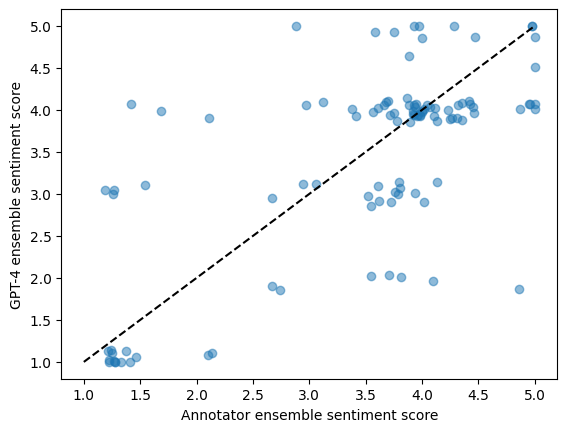

In [15]:
# plot with some jitter
def jitter(values, j, min=1, max=5):
    values = values + np.random.uniform(-j, j, values.shape)
    return np.clip(values, min, max)


x = annotations_df['Human ensemble']
y = annotations_df['GPT-4']
plt.plot(jitter(x, 0.15), jitter(y, 0.15), 'o', alpha=0.5)
plt.xlabel('Annotator ensemble sentiment score')
plt.ylabel('GPT-4 ensemble sentiment score')

plt.plot([1, 5], [1, 5], 'k--')

In [16]:
print('Fraction of time GPT-4 is more extreme than human',
      (np.abs(y[notna] - 3) > np.abs(x[notna] - 3)).mean())
print('Fraction of time GPT-4 reverses polarity',
      (((x >= 4) & (y <= 2)) | ((x <= 2) & (y >= 4)))[notna].mean()
      )

Fraction of time GPT-4 is more extreme than human 0.38095238095238093
Fraction of time GPT-4 reverses polarity 0.047619047619047616
